# Analyze performance of SAGA algorithm over different number of targets
Simulation of scenes with increasing density i.e. number of targets.
Performance indicators
1. Complexity analysis for Spatial Association (Graph edges, Number of evaluations, runtime)
2. RMSE for Range, doppler Estimation using FMCW radar beat signal
3. RMSE for position, velocity estimation using Gauss-Newton algorithm.
4. Overall metrics (localization error, cardinality error, OSPA)
5. Saves a movie of simulation with increasingly denser scene.
         
---
More details can be found in our paper: A. Gupta, A. D. Sezer and U. Madhow, "[Multi-Sensor Spatial Association Using Joint Range-Doppler Features](https://ieeexplore.ieee.org/abstract/document/9568701)," in IEEE Transactions on Signal Processing, vol. 69, pp. 5756-5769, 2021, doi: 10.1109/TSP.2021.3119418.

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import matplotlib.animation as animation
import time
# Custom libs
import GAutils.objects as ob
import GAutils.config as cfg # Sim parameters
import GAutils.proc_est as pr
import GAutils.simulate_snapshot2 as sim2
import GAutils.perf_eval as prfe
import GAutils.PCRLB as pcrlb

### Initialize simulation parameters

In [2]:
Nsens = 4 # Num Sensors
swidth = 4 # Width of sensor array
snr= -10 # SNR cfg.snra
Ninst = 7 # Range of parameters to sweep in simulation
Noba = np.linspace(1,19,Ninst, dtype='int') # cfg.Noba
Nf = 5 # Averaging for simulation 
pmiss = 0.05 # Prob of miss at each sensor
rob = 1 # Robustness level, rho

### Run simulation

In [3]:
# Naming algorithm names & Plotting
alg_name = ['Estimation', 'Graph Init.','Association','Refinement','All edges','Pruned edges',cfg.mode+'-F(A) evals',cfg.mode+'-L(A) evals']

# Intialize variables to log results
runtime = np.zeros([8,Ninst])
ospa_error1 = np.zeros([Ninst,Nf,5])
PVerror = np.zeros((Ninst, max(Noba),2))
rd_error = np.zeros([Ninst,Nf,2])
rd_err1 = np.zeros((Ninst, Nsens, max(Noba),2))
rd_err2 = np.zeros((Ninst, Nsens, max(Noba),2))
crb1 = np.zeros((Ninst, Nsens, max(Noba),2))
crbpv = np.zeros((Ninst, max(Noba),2))
present = np.zeros((Ninst, Nsens, max(Noba)))
Nmiss1=np.zeros((Ninst, Nsens))
Nfa1 =np.zeros((Ninst, Nsens))
grca = [[] for _ in range(Ninst)]
glena = np.zeros((Ninst, 2*max(Noba))) # Keep enough space for 2x False alarms
Ndet = np.zeros((Ninst,Nf))
plt.close('all')
#for plt_n in range(1,6): plt.figure(plt_n), plt.clf()
# Convert to position, Vel bounds
crb_conv = pcrlb.CRBconverter()

#%%
# Generate sensor array
sx=np.linspace(-swidth/2, swidth/2, Nsens)
sensors = [ob.Sensor(x,0) for x in sx]
    
np.random.seed(29)
seeda = np.random.randint(1000, size=Nf)
# Generate Nf scenes with random set of targets 
scenea = [pr.init_random_scene(max(Noba), sensors, cfg.sep_th, seeda[f]) for f in range(Nf)]

t=time.time()
for inst in tqdm(range(Ninst), desc='Instances'):
    Nob = Noba[inst]

    cfgp = {'Nsel': [],# Genie info on # targets
            'rd_wt':cfg.rd_wt,
            'static_snapshot': cfg.static_snapshot,
            'sep_th':cfg.sep_th,
            'pmiss':pmiss,
            'estalgo':cfg.estalgo, 
            'osps':cfg.osps,
            'n_Rc':cfg.n_Rc,
            'n_pfa':cfg.n_pfa,
            # Association
            'rob':rob,
            'mode': cfg.mode,
            'hscale':cfg.hscale,
            'incr':cfg.incr,
            'hN': cfg.hN,
            'ag_pfa':cfg.ag_pfa,
            'al_pfa':cfg.al_pfa,
            'Tlen':cfg.Tlen,
            # Gauss Newton
            'gn_steps':cfg.gn_steps,
            'fu_alg':cfg.fu_alg
            }
#        print('Running {} of {} '.format(inst+1, Ninst))
    for f in range(Nf):#,desc='Averaging', leave=False):  # Loop over frames
        snapshot_result = sim2.run_snapshot(scenea[f][0:Nob], sensors, snr, cfgp, seeda[f])

        Ndet[inst, f] = len(snapshot_result['loc']) # Count target associated
        runtime[:,inst] += snapshot_result['runtime']
        ospa_error1[inst,f,:] += snapshot_result['OSPAerror1'] # track based

        glen = snapshot_result['glen']
        glena[inst,:len(glen)] += np.array(glen)
        ret, det, Nmisst, Nfat, crbt, presentt = snapshot_result['RDpack']#prfe.compute_rde_targetwise(garda_sel, gardat, sensors)
        rd_error[inst,f,:] += np.sum(snapshot_result['RDerror'],axis =1) # Already Mutiplied by number of targets detected
        grca[inst].append( snapshot_result['loc'] )
        rd_err1[inst,:Nsens,:Nob,0] += np.array(ret)
        rd_err1[inst,:Nsens,:Nob,1] += np.array(det)
        rd_err2[inst,:Nsens,:Nob,0] += np.array(ret)**2
        rd_err2[inst,:Nsens,:Nob,1] += np.array(det)**2

        present[inst,:Nsens,:Nob] +=presentt
        crb1[inst,:Nsens,:Nob] += snapshot_result['crbrd']/Nf #crbt
        Nmiss1[inst,:Nsens] += Nmisst
        Nfa1[inst,:Nsens] += Nfat

        [_,_,_,_,crbp, crbv] = crb_conv.get_CRBposvel_from_rd(snapshot_result['crbr'], snapshot_result['crbd'], sensors, scenea[f][0:Nob])
        snapshot_result['crbpv'] = np.stack([np.array(crbp)**2, np.array(crbv)**2],axis=-1)

        crbpv[inst,:Nob] += snapshot_result['crbpv']/Nf
        PVerror[inst,:Nob] += snapshot_result['PVerror']/Nf
#            for i in range(3,5):
#                print(grca[inst][0][i-3].x)
#                print(ospa_error1[inst,f,i])
        #Average or update scene
#         if not static_snapshot: scene = snapshot_result['next_scene'] # Update scene for next timestep

print('Processing took {} s.'.format(time.time()-t))

Instances:   0%|                                         | 0/7 [00:00<?, ?it/s]/Users/anantgupta/Github/SAGA/demo/GAutils/objects.py:236: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x2, FAA, rank, s = np.linalg.lstsq(H,np.vstack((Me, Me2_centered)).T)
Instances: 100%|█████████████████████████████████| 7/7 [00:05<00:00,  1.32it/s]

Processing took 5.322144031524658 s.


# Plot the results from logged data

In [4]:
#%% Mask the arrays for averaging
mask1 = np.ones((Ninst, Nsens, max(Noba),2))
for i in range(Ninst):
    mask1[i,:Nsens,:Noba[i],:]=0
rd_err1 = np.ma.array(rd_err1, mask=mask1)
rd_err2 = np.ma.array(rd_err2, mask=mask1)
crb1 = np.ma.array(crb1, mask=mask1)
present = np.ma.array(present, mask=mask1[:,:,:,0])
Nmiss1=np.ma.array(Nmiss1, mask=mask1[:,:,0,0])
Nfa1 =np.ma.array(Nfa1, mask=mask1[:,:,0,0])
crbpv = np.ma.array(crbpv, mask=mask1[:,0,:,:])
PVerror = np.ma.array(PVerror, mask=mask1[:,0,:,:])
rng_used = Noba
units=['(m)','(m/s)']
xlbl = 'Num Targets'

In [5]:
def resizefig(plt, x, y):
    fig = plt.gcf()
    fig.set_size_inches(x,y)
    plt.tight_layout()

### Association complexity Analysis using
1. Number of evals
2. Runtime

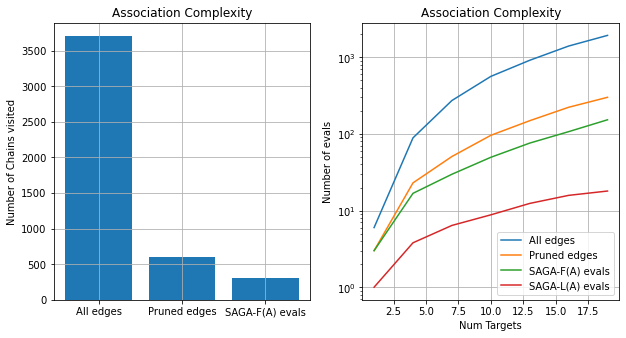

In [6]:
# Number of evals
plt.figure(11)
plt.subplot(1,2,1)
plt.bar(range(3), np.mean(runtime[4:7], axis=1), tick_label=alg_name[4:7]),plt.grid(True)
plt.ylabel('Number of Chains visited'),plt.title('Association Complexity')
plt.subplot(1,2,2)
pltn={}
for i in range(4,8):
    pltn[i]= plt.plot(rng_used, runtime[i,:]/Nf, label = alg_name[i]),plt.grid(True)
plt.legend(),plt.xlabel(xlbl),plt.ylabel('Number of evals'),plt.title('Association Complexity')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(8.8,4.8)
plt.tight_layout()

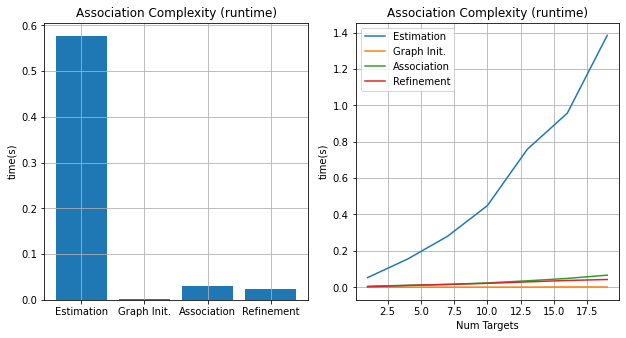

In [7]:
# plt.switch_backend('Qt4Agg')  

plt.figure(1)
plt.subplot(1,2,1)
plt.bar(range(4), np.mean(runtime[:4], axis=1), tick_label=alg_name[:4]),plt.grid(True)
plt.title('Association Complexity (runtime)'),plt.ylabel('time(s)')
plt.subplot(1,2,2)
pltn={}
for i in range(4):
    pltn[i]= plt.plot(rng_used, runtime[i,:], label = alg_name[i]),plt.grid(True)
plt.legend(),plt.xlabel(xlbl),plt.title('Association Complexity (runtime)'),plt.ylabel('time(s)')
fig = plt.gcf()
fig.set_size_inches(8.8,4.8)
plt.tight_layout()

### Localization accuracy
1. Range-Doppler estimation RMS error
2. Position-velocity estimation RMS error

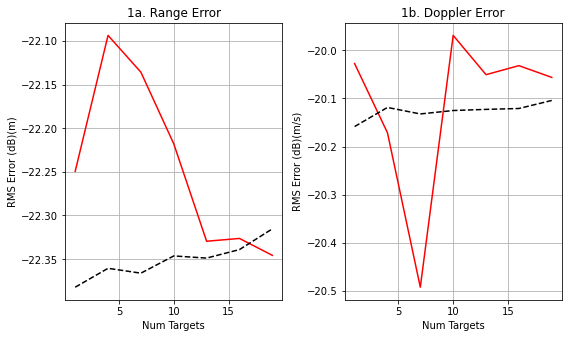

In [8]:
capt4 = ['1a. Range Error','1b. Doppler Error']
plt.figure(4)
for i in range(2):
    plt.subplot(1,2,i+1)
    # plt.plot(rng_used, 10*np.log10(np.sum(np.sqrt(rd_err2[:,:,:,i]), axis =(1,2))/np.sum(present,axis=(1,2))), 'r-', label='RMSE')
    plt.plot(rng_used, 10*np.log10(np.sqrt(np.sum(rd_err2[:,:,:,i], axis =(1,2))/np.sum(present,axis=(1,2)))), 'r-', label='RMSE')
    plt.plot(rng_used, 10*np.log10(np.sqrt(np.mean(crb1[:,:,:,i], axis=(1,2)))), 'k--', label='CRB')
#        plt.plot(rng_used, 10*np.log10(np.mean(np.sqrt(crb1[:,:,:,i]), axis=(1,2))), 'k--', label='CRB')
    plt.xlabel(xlbl),plt.ylabel('RMS Error (dB)'+units[i]),plt.title(capt4[i]),plt.grid(True),plt.yscale('linear')
resizefig(plt, 8,4.8)

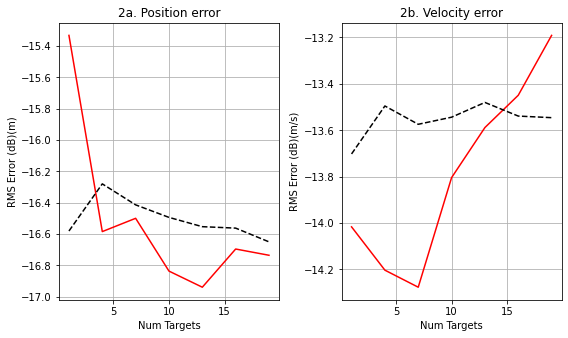

In [9]:
capt2 = ['2a. Position error','2b. Velocity error']
plt.figure(2)
for i in range(3,5):
    plt.subplot(1,2,i-2)
    # Find where are non zero PVerrors
    PVTemp = PVerror[:,:,i-3]
    CRBTemp = crbpv[:,:,i-3]
    plt.plot(rng_used, 10*np.log10([np.mean(np.sqrt(PVi[PVi>0])) for PVi in PVTemp]
            ), color='r', label='RMSE')
    plt.plot(rng_used, 10*np.log10([np.mean(np.sqrt(CRBT[PVi>0])) for (PVi,CRBT) in zip(PVTemp,CRBTemp)]
            ), 'k--', label='CRB'),plt.yscale('linear')
    plt.xlabel(xlbl),plt.ylabel('RMS Error (dB)'+units[i-3]),plt.title(capt2[i-3]),plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(8,4.8)
plt.tight_layout()

## Graphical Association 
1. Graph size at the end of each iteration of association algorithm
2. Model order estimation accuracy

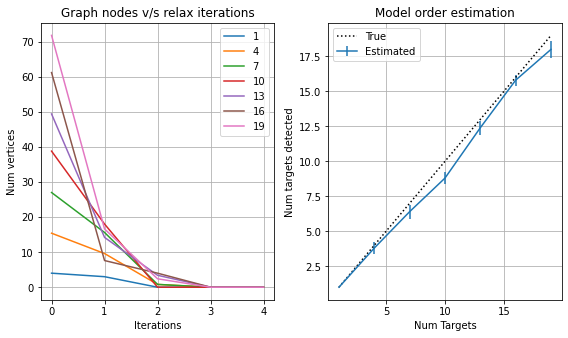

In [10]:
plt.figure(10)
plt.subplot(1,2,1)
for i in range(Ninst):
    hN_max = np.count_nonzero(glena[i,:])
    plt.plot(range(hN_max+2), (glena[i,:hN_max+2]/Nf), label = str(rng_used[i]))
plt.legend(),plt.grid(True),plt.title('Graph nodes v/s relax iterations'),plt.ylabel('Num vertices'),plt.xlabel('Iterations')
plt.subplot(1,2,2)
plt.errorbar(rng_used, np.mean(Ndet, axis=1), np.std(Ndet, axis =1), label = 'Estimated')
plt.plot(rng_used, Noba, 'k:', label = 'True')
plt.legend(),plt.grid(True),plt.title('Model order estimation'),plt.ylabel('Num targets detected'),plt.xlabel(xlbl)
resizefig(plt, 8,4.8)

Overall performance metrics

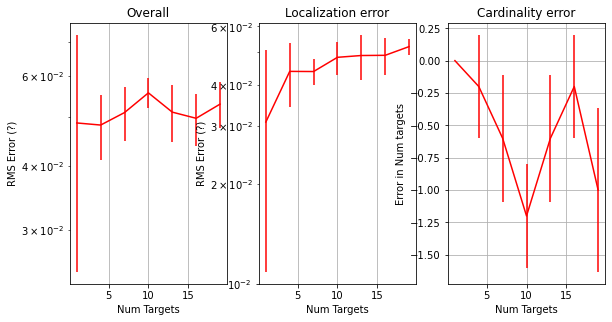

In [11]:
capt3 = ['Overall','Localization error','Cardinality error']
plt.figure(3)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.errorbar(rng_used, np.mean(ospa_error1[:,:,i], axis=1), np.std(ospa_error1[:,:,i], axis=1), color='r')
    plt.xlabel(xlbl),plt.title(capt3[i]),plt.grid(True)
    if i<=1:
        plt.yscale('log'), plt.ylabel('RMS Error (?)')
    else:
        plt.ylabel('Error in Num targets')

fig = plt.gcf()
fig.set_size_inches(9.6,4.8)

## Illustration of simulation results using a movie

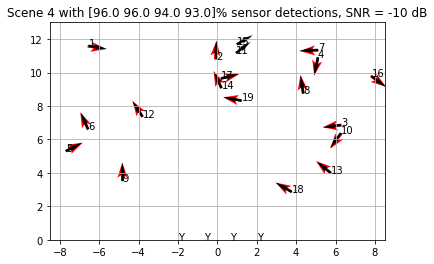

In [12]:
from IPython.display import Video
# Setup video files
if 1:#cfg.movie:
    try:
        FFMpegWriter = animation.writers['ffmpeg']
        metadata = dict(title='Movie Test', artist='Anant',comment='Target motion')
        writer = FFMpegWriter(fps=1, metadata=metadata)
        fig = plt.figure(15)
        with writer.saving(fig, 'Scenes.mp4', dpi=128):
            cnt = 0
            phlista = []
            for i, scene in enumerate(scenea):
                for j in range(Ninst):
                    phlist = grca[j][i]
                    phlista.append(phlist)
                    cnt = cnt +1
                    plt.clf()
                    for gr in phlist: 
                        if abs(gr.vx)+abs(gr.vy)>0:
                            plt.quiver(gr.x, gr.y,gr.vx,gr.vy, color='r', headwidth = 4, headlength=6, headaxislength=5)
                        else:
                            plt.plot(gr.x, gr.y, 'ro')
                    pr.plot_scene(plt, scene[:Noba[j]], sensors, 15, 'Scene {} with {}% sensor detections, SNR = {} dB'.format(i, np.round(100*np.sum(present[j,:,:],axis=1)/Nf/Noba[j]), round(snr)))
                    writer.grab_frame()
    except Exception as e: print(e)
    
Video("Scenes.mp4")